# IOOS Access 01: Accessing observations data via the IOOS Catalog OGC CSW endpoint
[Emilio Mayorga](https://github.com/emiliom), University of Washington & [NANOOS](http://www.nanoos.org/). 2018-8-21.

From https://data.ioos.us/about (1): 

> The IOOS Catalog (https://data.ioos.us/) is an open data portal containing IOOS’ portfolio of oceanographic observations and forecast products distributed by IOOS’ 11 Regional Associations (RAs), functional Data Assembly Centers (DACs) such as the HF Radar DAC and Glider DAC, and IOOS’ federal partners. The Catalog inventories all IOOS Data Management (DMAC)-compliant data access service endpoints provided by these entities in a single metadata repository, for discovery by end users. 
> 
> The Catalog provides a searchable user graphical user interface (https://data.ioos.us/) for interactive data discovery by users, as well as a native API (https://data.ioos.us/api/3) and OGC CSW (2) (https://data.ioos.us/csw?service=CSW&request=GetCapabilities) -compatible service for machine-based access to its inventory of data products.

This notebook demonstrates a search of the IOOS Catalog OGC CSW endpoint with filters to return results for:
- (a) Spatial bounding box for the OOI Coastal Endurance array;
- (b) time span of "today minus 5 days";
- (c) variable: sea water temperature

Results are then explored and further filtered by a specific web service type that is limited to observation data (rather than model forecasts). Further exploration include using the web service request metadata to issue time series data requests to the source service providers, and plotting the data.

The IOOS notebook at http://ioos.github.io/notebooks_demos/notebooks/2018-03-30-wave_height_assessment/ has some relevant, related materials, though it's not the origin of this notebook, per se.

(1) https://data.ioos.us/about also discusses current limitations of the IOOS Catalog, and current plans for enhancements.    
(2) [OGC CSW: Open Geospatial Consortium Catalog Service for the Web](https://en.wikipedia.org/wiki/Catalog_Service_for_the_Web)

## Preamble

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
from folium import IFrame

/home/mayorga/miniconda/envs/ioosaccess/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 1. Define the Endurance Array bounding box and map the area using a simple GeoPandas plot
http://oceanobservatories.org/array/coastal-endurance/

In [2]:
import shapely.geometry as shpgeom

min_lon, max_lon = -127, -123.75
min_lat, max_lat = 43, 48

endurance_bbox_shp = shpgeom.box(min_lon, min_lat, max_lon, max_lat)
endurance_bbox_gs = gpd.GeoSeries(endurance_bbox_shp)

Create simple map plot for reference, using `cartopy`, cartopy coastlines, and openly available map tiles (StamenTerrain) as a base map.

In [3]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import StamenTerrain

/home/mayorga/miniconda/envs/ioosaccess/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


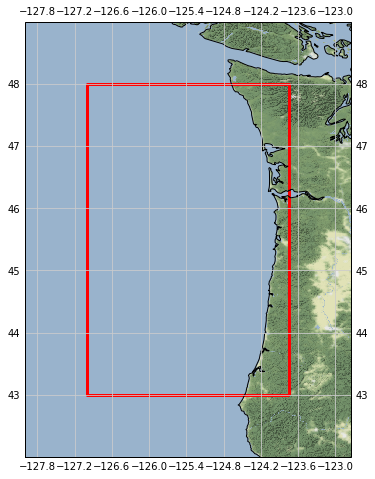

In [4]:
fig, ax = plt.subplots(1, figsize=(8, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent((min_lon-1, max_lon+1, min_lat-1, max_lat+1))

ax.add_image(StamenTerrain(), 8)
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True, color='0.8')

endurance_bbox_gs.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=3);

## 2. Create the catalog query filters and issue the OGC CSW query to the IOOS Catalog web service

In [5]:
from owslib import fes

**(a) Spatial bounding box.** Everything overlapping the Endurance Array bounding box defined above

In [6]:
bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

bbox_crs = fes.BBox(bbox, crs=crs)

**(b) Time span.** Today - 5 days.

In [7]:
from datetime import datetime, timedelta
# ioos_tools is an IOOS "helper" package. https://github.com/pyoceans/ioos_tools
from ioos_tools.ioos import fes_date_filter


days = 5

now_datetime_utc = datetime.utcnow()
start = now_datetime_utc - timedelta(days=days)
stop = now_datetime_utc

begin, end = fes_date_filter(start, stop)

/home/mayorga/miniconda/envs/ioosaccess/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


**(c) Variable.** `sea_water_temperature`, plus related variables. (All names in `cf_names` are [CF standard names](http://cfconventions.org/standard-names.html),
but we can uses non-CF parameter names like 'Water Temperature' to try to get more datasets.)

In [8]:
# The last 3 variables are typically used by models (I think)
cf_names = [
    'sea_water_temperature',
    'sea_surface_temperature',
    'sea_water_potential_temperature',
    'equivalent_potential_temperature',
    'sea_water_conservative_temperature',
    'pseudo_equivalent_potential_temperature',
]

kw = dict(
    wildCard='*',
    escapeChar='\\',
    singleChar='?',
    propertyname='apiso:AnyText'
)

or_filt = fes.Or(
    [fes.PropertyIsLike(literal=('*%s*' % val), **kw)
        for val in cf_names])

Assemble the OGC `fes` filter with `a`+`b`+`c`, then issue the OGC CSW query request.

In [9]:
filter_list = [
    fes.And(
        [
            bbox_crs,
            begin, end,
            or_filt,
            # Excluding "CDIP" because there are currently problems with those datasets in the Catalog
            fes.Not([fes.PropertyIsLike(literal='*cdip*', **kw)]), 
            # Excluding "GRIB" files because they are typically from models, are more complex, and we don't want to deal with them here
            fes.Not([fes.PropertyIsLike(literal='*grib*', **kw)]),
        ]
    )
]

In [10]:
from owslib.csw import CatalogueServiceWeb
from ioos_tools.ioos import get_csw_records


endpoint = 'https://data.ioos.us/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)

get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))

Found 26 records.



Display a summary of all the records found. Note that while some are observations, a few are model output.

In [11]:
for key, value in list(csw.records.items()):
    print(u'[{}]\n  {}'.format(value.title, key))

[urn:ioos:station:NOAA.NOS.CO-OPS:9437540 station, Garibaldi, OR]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9437540
[urn:ioos:station:NOAA.NOS.CO-OPS:9439040 station, Astoria, OR]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9439040
[urn:ioos:station:NOAA.NOS.CO-OPS:9440581 station, Cape Disappointment]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440581
[urn:ioos:station:NOAA.NOS.CO-OPS:9440910 station, Toke Point, WA]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440910
[urn:ioos:station:NOAA.NOS.CO-OPS:9441102 station, Westport, WA]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9441102
[urn:ioos:station:NOAA.NOS.CO-OPS:9442396 station, La Push, WA]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9442396
[(CMOP) SATURN-02]
  data.nanoos.org-urn_ioos_station_nanoos_cmop_ogi02
[(CMOP) SATURN-03]
  data.nanoos.org-urn_ioos_station_nanoos_cmop_saturn03
[(CMOP) SATURN-04]
  data.nan

## 3. Explore what a catalog metadata record looks like
We'll pick one result and explore it a bit, a tide gage (with other sensors) from NOAA NOS-COOPS

In [12]:
asset_id = 'opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9437540'

cswrec = csw.records[asset_id]

The raw catalog response records are Dublin Core XML records with OGC elements.

In [13]:
# pretty print xml
import xml.dom.minidom

cswrec_parsedxml = xml.dom.minidom.parseString(cswrec.xml)
print(cswrec_parsedxml.toprettyxml(indent='    '))

<?xml version="1.0" ?>
<csw:SummaryRecord xmlns:csw="http://www.opengis.net/cat/csw/2.0.2" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:dct="http://purl.org/dc/terms/" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gml="http://www.opengis.net/gml" xmlns:ows="http://www.opengis.net/ows" xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <dc:identifier>opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9437540</dc:identifier>
    <dc:title>urn:ioos:station:NOAA.NOS.CO-OPS:9437540 station, Garibaldi, OR</dc:title>
    <dc:type>dataset</dc:type>
    <dc:subject>Air Temperature</dc:subject>
    <dc:subject>Barometric Pressure</dc:subject>
    <dc:subject>Conductivity</dc:subject>
    <dc:subject>Currents</dc:subject>
    <dc:subject>Datum</dc:subject>
    <dc:subject>Harmonic Constituents</dc:subject>
    <dc:subject>Rain Fall</dc:subject>
    <dc:subject>Relative Humidity</dc:subject>
    <dc:subject>Salinity</dc:subjec

### Detecting and inferring types of data service end point

The records that are returned by the catalog provide data access via several web service types and data encodings. The most widely implemented in the IOOS network at this time for observations is the IOOS profile of the OGC SOS (Sensor Observation Service). Data services using this protocol provide data responses in an IOOS CSV structure and/or the IOOS O&M / SWE Common XML encoding. See https://ioos.github.io/ for complete technical  details.
We'll explore first how web service and response encoding types are presented in the CSW response records. These are found in the `dct:references@scheme` elements in the example above, and in the records in general.   Standardized labels of web service and encoding types are being developed by the community at https://github.com/OSGeo/Cat-Interop, but both the definitions and their implementations remain a work in progress. A tool that leverages these service labels is [geolinks.sniff_link](https://github.com/geopython/geolinks), which we'll explore here.

In [14]:
len(cswrec.references)

9

In [15]:
# display a small subset of the "references"
cswrec.references[:3]

[{'scheme': 'OGC:SOS:DescribeSensor',
  'url': 'https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?procedure=urn:ioos:station:NOAA.NOS.CO-OPS:9437540&request=DescribeSensor&outputFormat=text/xml; subtype="sensorML/1.0.1/profiles/ioos_sos/1.0"&service=SOS&version=1.0.0'},
 {'scheme': 'WWW:LINK - text/csv',
  'url': 'http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?eventTime=2018-08-19T16:12:59None/2018-08-19T18:12:59None&request=GetObservation&version=1.0.0&responseFormat=text/csv&offering=urn:ioos:station:NOAA.NOS.CO-OPS:9437540&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/air_pressure'},
 {'scheme': 'WWW:LINK - text/csv',
  'url': 'http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?eventTime=2018-08-19T16:12:59None/2018-08-19T18:12:59None&request=GetObservation&version=1.0.0&responseFormat=text/csv&offering=urn:ioos:station:NOAA.NOS.CO-OPS:9437540&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/sea_surface_height_amplitude_due_to_equilibrium_ocea

In [16]:
# Apply geolinks.sniff_link

from geolinks import sniff_link


df = []
for key, rec in csw.records.items():
    df.append(pd.DataFrame(rec.references))

df = pd.concat(df, ignore_index=True)
df['geolink'] = [sniff_link(url) for url in df['url']]

Let's compare `geolink.sniff_link` and raw reference `scheme` results. Unfortunately they're not identical.

In [17]:
df.groupby(['geolink', 'scheme']).size()

geolink          scheme                     
OGC:SOS          OGC:SOS                         20
                 OGC:SOS:DescribeSensor          20
                 WWW:LINK - application/json    113
                 WWW:LINK - text/csv             45
                 WWW:LINK - text/xml            113
OGC:WCS          OGC:WCS                          3
OGC:WMS                                           2
                 OGC:WMS                          3
OPeNDAP:OPeNDAP                                   1
                 OPeNDAP:OPeNDAP                  1
                 WWW:LINK                         3
UNIDATA:NCSS     UNIDATA:NCSS                     3
WWW:LINK         WWW:LINK                         3
                 http                             2
dtype: int64

Here's one example:

In [18]:
df.loc[df['scheme'] == 'OGC:SOS', 'url'].value_counts()

http://data.nanoos.org/52nsos/sos/kvp?acceptVersions=1.0.0&request=GetCapabilities&service=SOS                  13
http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?acceptVersions=1.0.0&request=GetCapabilities&service=SOS     7
Name: url, dtype: int64

## 4. Get observations time series data and create plots and maps

We'll settle on using the `scheme` results. OGC SOS data results are obtained via the `GetObservation` request. For now, we'll focus only on records with [IOOS CSV GetObservation responses](http://ioos.github.io/ioos-csv-tsv/). Selecting this service type automatically eliminates model forecasts (**Notebook 3 will explore model forecast results**).

We only need to correct the dates on the GetObservation URLs because the ones in the CSW records are for one day only, by default.

In [19]:
import re

def fix_series(url, start, stop):
    url_split = re.split('[&?]', url)
    new_url = []
    for line in url_split:
        if line.startswith('eventTime='):
            line = f'eventTime={start:%Y-%m-%dT%H:%m:00}/{stop:%Y-%m-%dT%H:%m:00}'
        new_url.append(line)

    return "{}?{}".format(new_url[0], '&'.join(new_url[1:]))

In [20]:
sos_urls = [
    fix_series(url, start, stop) for url in df.loc[df['geolink'] == 'OGC:SOS', 'url']
    if 'GetObservation' in url 
    and 'text/csv' in url 
    and cf_names[0] in url
]

len(sos_urls)

6

6 sites are returned. We'll compile the downloaded site time series in the `observations` list containing Pandas data frames (one data frame per site time series).

In [21]:
observations = []
for url in sos_urls:
    observations.append(
        pd.read_csv(url, index_col='date_time', parse_dates=True)
    )

*Later this week we'll add sample code for handling the SOS GetObservation "XML O&M" response type, accessed and parsed using the IOOS-developed [pyoos](https://github.com/ioos/pyoos/) client software.*

Now, create inline time series plot showing all sites that we downloaded.

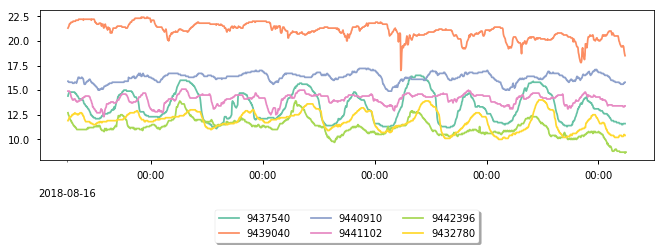

In [22]:
from itertools import cycle


def mpl_palette(cmap, n_colors=6):
    brewer_qual_pals = {"Accent": 8, "Dark2": 8, "Paired": 12,
                        "Pastel1": 9, "Pastel2": 8,
                        "Set1": 9, "Set2": 8, "Set3": 12}

    if cmap.name in brewer_qual_pals:
        bins = np.linspace(0, 1, brewer_qual_pals[cmap.name])[:n_colors]
    else:
        bins = np.linspace(0, 1, n_colors + 2)[1:-1]
    palette = list(map(tuple, cmap(bins)[:, :3]))

    pal_cycle = cycle(palette)
    palette = [next(pal_cycle) for _ in range(n_colors)]
    
    return palette

with mpl.style.context('seaborn-notebook'):
    fig, ax = plt.subplots(figsize=(11, 2.75))
    colors = mpl_palette(plt.cm.Set2, n_colors=len(observations))
    for k, series in enumerate(observations):
        station_name = series['station_id'].iloc[0].split(':')[-1]
        ax.plot(series.index, series['sea_water_temperature (C)'], label=station_name, color=colors[k])
    leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
                    ncol=3, fancybox=True, shadow=True)

hours = mpl.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(hours)

days = mpl.dates.DateFormatter('\n\n%Y-%m-%d')
ax.xaxis.set_minor_formatter(days)
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([mpl.dates.date2num(start)]))

## 5. Map the sites in a Folium map, with pop-ups that include corresponding time series plots

In [23]:
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html


# Create a marker pop-up element for each site, with a time series plot using Bokeh

def make_marker(series):
    width, height = 500, 250

    station = series['station_id'].iloc[0]
    lat = series['latitude (degree)'].iloc[0]
    lon = series['longitude (degree)'].iloc[0]

    p = figure(
        x_axis_type='datetime',
        title=station,
        width=width, height=height)
    p.line(series.index, series['sea_water_temperature (C)'], line_width=2)
    html = file_html(p, CDN, station)
    iframe = IFrame(html, width=width+40, height=height+80)
    
    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color='green', icon='stats')
    marker = folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=icon
    )
    return marker

### Initialize the Folium map, then add elements to it

In [24]:
tiles = 'http://services.arcgisonline.com/arcgis/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}'

m = folium.Map(tiles=tiles, attr='ESRI')

In [25]:
for series in observations:
    make_marker(series).add_to(m)

Add the Endurance Array bounding box, then generate the Folium map. This map could be enhanced with markers for the observations records returned by the original CSW query that we didn't download time series data for. That information is available in `csw.records`.

In [26]:
# Look into adding a popup?
folium.GeoJson(endurance_bbox_shp.__geo_interface__,
              style_function=lambda feature: {'color': 'red', 'fillOpacity': 0.0}
              ).add_to(m)

m.fit_bounds(m.get_bounds())

m